# Dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

In [35]:
def det3(a, b, c):
    return (a[0]*b[1] + b[0]*c[1] + c[0]*a[1]) - (c[0]*b[1] + b[0]*a[1] + a[0]*c[1])

def orient(a, b, c, e=1e-12):
    d = det3(a, b, c)
    if d > e:
        return 1
    elif d <-e:
        return -1
    else:
        return 0
    
# def cross(a, b):
#     return a[0]*b[1] - a[1]*b[0]

class Edge:
    def __init__(self, p1, p2):
        self.p1 = p1 #first point
        self.p2 = p2 #second point
        
    def __eq__(self, other):
        #symetric edges
        return (self.p1 == other.p1 and self.p2 == other.p2) or (self.p1 == other.p2 and self.p2 == other.p1)
    
    def __hash__(self):
        return hash((self.p1, self.p2))
    
    def __str__(self):
        return "{" + str(self.p1) + "," + str(self.p2) + "}"
    
    def __repr__(self):
        return "{" + str(self.p1) + "," + str(self.p2) + "}"
    
class Tr:
    def __init__(self, e1, e2, e3):
        #e1,e2,e3 - edges of triangle CCW
        self.edges = set([e1, e2, e3])
        self.neigh = []
        self.active = True
        
    def circumcircle(self):
        '''
        midpoint and radius of circumcircle
        https://en.wikipedia.org/wiki/Circumscribed_circle
        '''
        pts = []
        for edge in self.edges:
            pts.append(edge.p1)
        
        a = pts[0][0]**2 + pts[0][1]**2
        b = pts[1][0]**2 + pts[1][1]**2
        c = pts[2][0]**2 + pts[2][1]**2
        
        t = det3(pts[0], pts[1], pts[2])
        
        sx = (1/2) * det3([a, pts[0][1]],[b, pts[1][1]], [c, pts[2][1]]) / t
        sy = (1/2) * det3([pts[0][0], a],[pts[1][0], b], [pts[2][0], c]) / t
        s = np.array([sx, sy])
        
        return (s, np.linalg.norm(s-pts[0]))
    
    def neighBy(self, edge, triangulation):
        for n in self.neigh:
            if edge in triangulation[n].edges or Edge(edge.p2, edge.p1) in triangulation[n].edges:
                return n
    
    def contains(self, point):
        for e in self.edges:
            if det3(e.p1, e.p2, point) > 0:
                return False
        return True
    
    def circumcircleContains(self, point):
        s, r = self.circumcircle()
        return np.linalg.norm(s-point) < r
    
#     def centroid(self):
#         pts = []
#         for edge in self.edges:
#             pts.append(edge.p1)
#         s = [(pts[0][0] + pts[1][0] + pts[2][0])/3, (pts[0][1] + pts[1][1] + pts[2][1])/3]
#         return np.array(s)
    
#     def dist(self, point):
#         s = self.centroid()
#         return np.linalg.norm(s-point)
    
#     def closerNeigh(self, triangulation, pe):
#         pb = self.centroid()
#         for e in self.edges:
#             r = pe-pb
#             s = np.array(e.p2)-np.array(e.p1)
#             cr = cross(r, s)
#             if cr != 0:
#                 u = cross(np.array(e.p1)-pb, r)/cr
#                 t = cross(np.array(e.p1)-pb, s)/cr
#                 if u <= 1 and t <= 1:
#                     n = self.neighBy(e, triangulation)
#                     if n is not None:
#                         return n
    
    def __eq__(self, other):
        return len(self.edges - other.edges) == 0
    
    def __hash__(self):
        es = []
        for e in self.edges:
            es.append(e)
        return hash(tuple(es))

In [36]:
def badDFS(tr, point, visited, badTrs, triangulation):
    visited.add(tr)
    if triangulation[tr].circumcircleContains(point):
        badTrs.append(tr)
        for n in triangulation[tr].neigh:
            if n not in visited:
                badDFS(n, point, visited, badTrs, triangulation)

def triangulate(points):
    #random shuffle
    points = np.random.permutation(points)
    
    y_max, y_min = max(points[:,1].tolist()), min(points[:,1].tolist())
    x_max, x_min = max(points[:,0].tolist()), min(points[:,0].tolist())
    
    m = max([abs(y_max), abs(y_min), abs(x_max), abs(x_min)])
    
    #create super-triangle
    superTr = Tr(Edge((-10*m, -10*m), (0, 10*m)), Edge((0, 10*m), (10*m, 0)), Edge((10*m, 0), (-10*m, -10*m)))
    triangulation = [superTr]
    conTr = 0
    
    #triangulation
    #https://en.wikipedia.org/wiki/Bowyer%E2%80%93Watson_algorithm
    for p in points:
#         print("start", conTr)
#         while not triangulation[conTr].contains(p):
#             conTr = triangulation[conTr].closerNeigh(triangulation, p)
        #find triangle, which contains point
        for i,tr in enumerate(triangulation):
            if tr.active:
                if tr.contains(p):
                    conTr = i
                    break
            
        #find triangles to remove
        visited = set([conTr])
        badTrs = [conTr]
        for n in triangulation[conTr].neigh:
            badDFS(n, p, visited, badTrs, triangulation)
                
        edges = {} #number of edge occurrences in badTrs 
        for tr in badTrs:
            triangulation[tr].active = False
            for e in triangulation[tr].edges:
                if e in edges:
                    edges[e][0] += 1
                else:
                    if Edge(e.p2, e.p1) in edges: #symetric edge
                        edges[Edge(e.p2, e.p1)][0] += 1
                    else:
                        n = triangulation[tr].neighBy(e, triangulation)
                        if n is not None:
                            triangulation[n].neigh.remove(tr)
                            triangulation[tr].neigh.remove(n)
                        edges[e] = [1, n]
        
        #sort edges of polygon
        edges = [(k, v[1]) for k, v in edges.items() if v[0] == 1]
        sorted_edges = [edges[0]]
        for i in range(1, len(edges)):
            for j in range(1, len(edges)):
                if edges[j][0].p1 == sorted_edges[i-1][0].p2:
                    sorted_edges.append(edges[j])
                    break
        
        #add triangles with neighbors
        t = len(triangulation)
        for i in range(len(sorted_edges)):
            tr = Tr(sorted_edges[i][0], Edge(sorted_edges[i][0].p2, tuple(p.tolist())), Edge(tuple(p.tolist()), sorted_edges[i][0].p1))
            tr.neigh = [t+((i-1) % len(sorted_edges)), t+((i+1) % len(sorted_edges))]
            if sorted_edges[i][1] is not None:
                tr.neigh.append(sorted_edges[i][1])
                triangulation[sorted_edges[i][1]].neigh.append(t+i)
            triangulation.append(tr)
            conTr = t+i

    #remove edges to super-triangle
    edges = set()
    for tr in triangulation:
        if not tr.active:
            continue
        for e in tr.edges:
            toAdd = True
            for sE in superTr.edges:
                if e.p1 == sE.p1 or e.p2 == sE.p1 or e.p1 == sE.p2 or e.p2 == sE.p2:
                    toAdd = False
            if toAdd:
                edges.add(e)
    
    return edges

In [4]:
%matplotlib notebook
def plot_res(res):
    for e in res:
        plt.plot([e.p1[0], e.p2[0]], [e.p1[1], e.p2[1]])

# Plot example

<IPython.core.display.Javascript object>


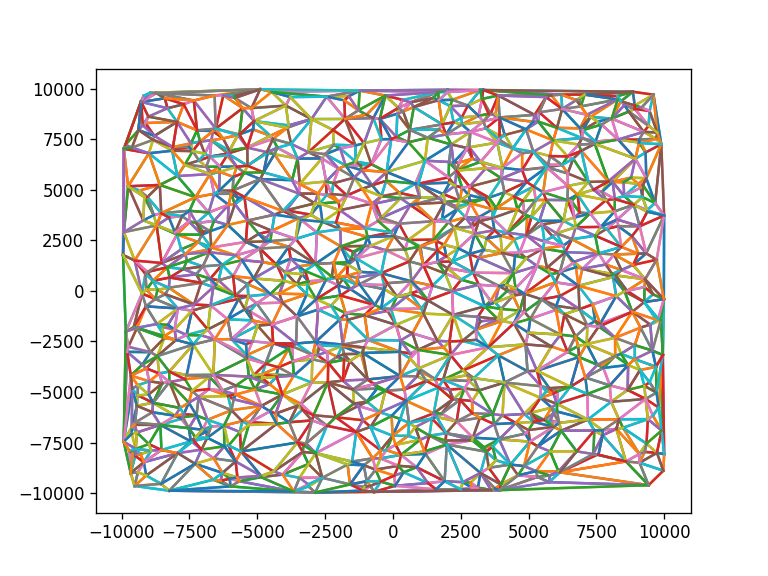

In [5]:
pts = np.random.uniform(-10000, 10000, size=(1000, 2))
res = triangulate(pts)
plot_res(res)

# Animation

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js
import timeit
import time

In [7]:
# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes, x_lim = None, y_lim = None):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []
        self.x_lim = x_lim
        self.y_lim = y_lim

    def set_axes(self, ax):
        self.ax = ax
        
    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
            
    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        if self.x_lim is not None and self.y_lim is not None:
            self.ax.set_xlim(self.x_lim)
            self.ax.set_ylim(self.y_lim)
        else:
            self.ax.autoscale(autoscaling)
        
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()

In [8]:
# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], x_lim = None, y_lim = None, json = None):
        self.x_lim = x_lim
        self.y_lim = y_lim
        
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes, self.x_lim, self.y_lim)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()

In [46]:
def get_lines(trs, superTr):
    edges = set()
    for tr in trs:
        if not tr.active:
            continue
        for e in tr.edges:
            toAdd = True
            for sE in superTr.edges:
                if e.p1 == sE.p1 or e.p2 == sE.p1 or e.p1 == sE.p2 or e.p2 == sE.p2:
                    toAdd = False
            if toAdd:
                edges.add(e)
    ret = []
    for e in edges:
        ret.append([e.p1, e.p2])
    return ret

def triangulate_scenes(points):
    scenes = []
    
    #random shuffle
    points = np.random.permutation(points)
    
    y_max, y_min = max(points[:,1].tolist()), min(points[:,1].tolist())
    x_max, x_min = max(points[:,0].tolist()), min(points[:,0].tolist())
    
    m = max([abs(y_max), abs(y_min), abs(x_max), abs(x_min)])
    
    #create super-triangle
    superTr = Tr(Edge((-10*m, -10*m), (0, 10*m)), Edge((0, 10*m), (10*m, 0)), Edge((10*m, 0), (-10*m, -10*m)))
    triangulation = [superTr]
    conTr = 0
    
    #triangulation
    #https://en.wikipedia.org/wiki/Bowyer%E2%80%93Watson_algorithm
    for p in points:
#         print("start", conTr)
#         while not triangulation[conTr].contains(p):
#             conTr = triangulation[conTr].closerNeigh(triangulation, p)
        #find triangle, which contains point
        for i,tr in enumerate(triangulation):
            if tr.active:
                if tr.contains(p):
                    conTr = i
                    break
            
        #find triangles to remove
        visited = set([conTr])
        badTrs = [conTr]
        for n in triangulation[conTr].neigh:
            badDFS(n, p, visited, badTrs, triangulation)
                
        edges = {} #number of edge occurrences in badTrs 
        for tr in badTrs:
            triangulation[tr].active = False
            for e in triangulation[tr].edges:
                if e in edges:
                    edges[e][0] += 1
                else:
                    if Edge(e.p2, e.p1) in edges: #symetric edge
                        edges[Edge(e.p2, e.p1)][0] += 1
                    else:
                        n = triangulation[tr].neighBy(e, triangulation)
                        if n is not None:
                            triangulation[n].neigh.remove(tr)
                            triangulation[tr].neigh.remove(n)
                        edges[e] = [1, n]
                        
        oldEdges = get_lines(triangulation, superTr)
        scenes.append(Scene(lines=[LinesCollection(oldEdges.copy(), color="blue")]))
        
        #sort edges of polygon
        edges = [(k, v[1]) for k, v in edges.items() if v[0] == 1]
        sorted_edges = [edges[0]]
        for i in range(1, len(edges)):
            for j in range(1, len(edges)):
                if edges[j][0].p1 == sorted_edges[i-1][0].p2:
                    sorted_edges.append(edges[j])
                    break
        
        #add triangles with neighbors
        newTr = []
        t = len(triangulation)
        for i in range(len(sorted_edges)):
            tr = Tr(sorted_edges[i][0], Edge(sorted_edges[i][0].p2, tuple(p.tolist())), Edge(tuple(p.tolist()), sorted_edges[i][0].p1))
            tr.neigh = [t+((i-1) % len(sorted_edges)), t+((i+1) % len(sorted_edges))]
            newTr.append(Tr(sorted_edges[i][0], Edge(sorted_edges[i][0].p2, tuple(p.tolist())), Edge(tuple(p.tolist()), sorted_edges[i][0].p1)))
            if sorted_edges[i][1] is not None:
                tr.neigh.append(sorted_edges[i][1])
                triangulation[sorted_edges[i][1]].neigh.append(t+i)
            triangulation.append(tr)
            conTr = t+i
            
        scenes.append(Scene(lines=[LinesCollection(oldEdges.copy(), color="blue"), LinesCollection(get_lines(newTr, superTr), color="red")]))
        scenes.append(Scene(lines=[LinesCollection(get_lines(triangulation, superTr), color="blue")]))     

    #remove edges to super-triangle
    edges = set()
    for tr in triangulation:
        if not tr.active:
            continue
        for e in tr.edges:
            toAdd = True
            for sE in superTr.edges:
                if e.p1 == sE.p1 or e.p2 == sE.p1 or e.p1 == sE.p2 or e.p2 == sE.p2:
                    toAdd = False
            if toAdd:
                edges.add(e)
    
    return scenes, get_lines(triangulation, superTr)

# Animation example

In [47]:
def animate(points):
    scenes, res = triangulate_scenes(points)
    
    x_max, x_min = max(points[:,0]), min(points[:,0])
    y_max, y_min = max(points[:,1]), min(points[:,1])
    plot = Plot(scenes, x_lim=(1.1*x_min, 1.1*x_max), y_lim=(1.1*y_min, 1.1*y_max))
    plot.draw()
    return plot

<IPython.core.display.Javascript object>


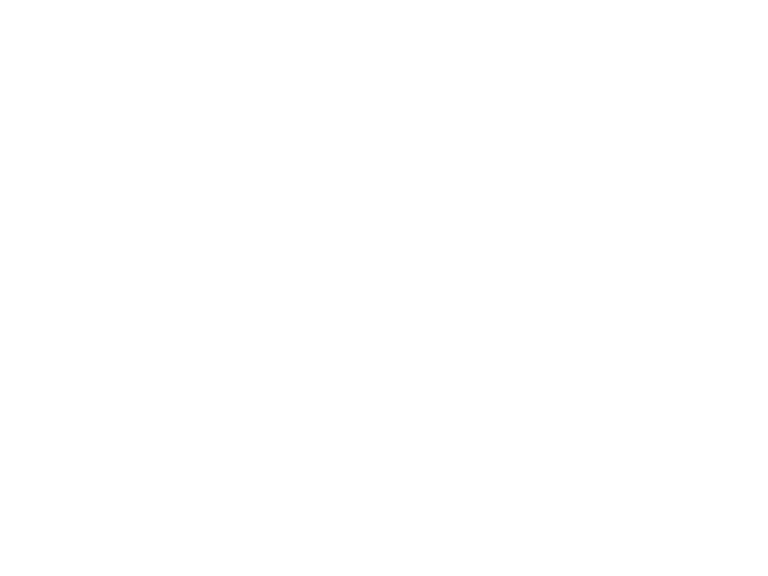

<IPython.core.display.Javascript object>

In [48]:
plot = animate(np.random.uniform(-1000, 1000, size=(50, 2)))
plot.draw()

# Draw points

<IPython.core.display.Javascript object>


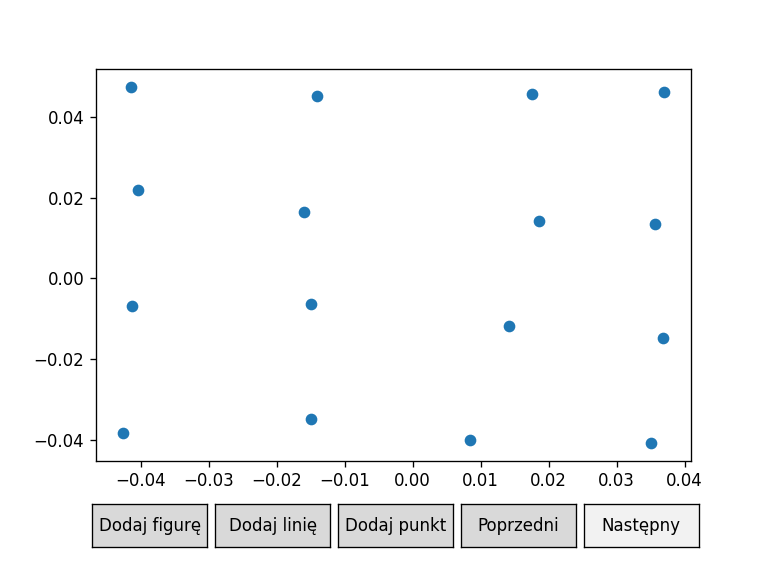

In [13]:
plot = Plot()
plot.draw()

<IPython.core.display.Javascript object>


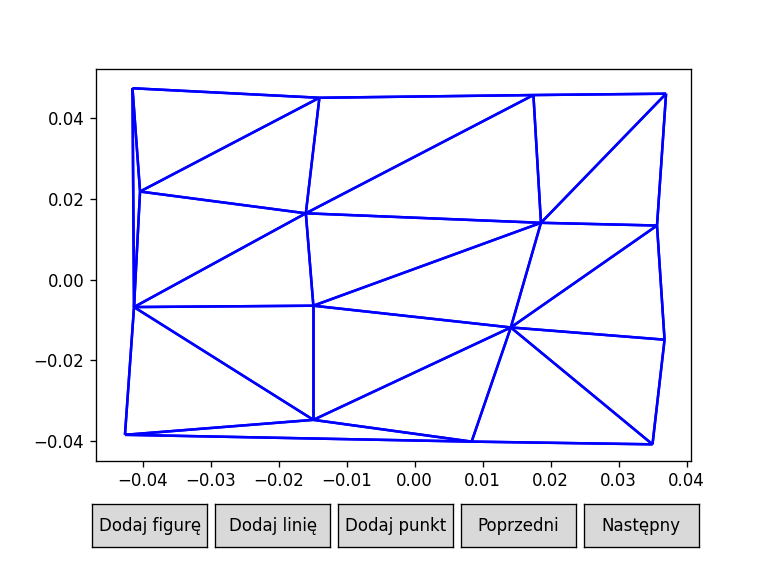

In [21]:
pts = plot.get_added_points()[0]
animate(np.array(pts.points))

# Reading from file

In [55]:
def read_points(file):
    return np.loadtxt(file)

In [56]:
def save_points(file, points):
    np.savetxt(file, points)

# Reading and saving example

In [59]:
points = np.random.uniform(-1000, 1000, size=(100, 2))
save_points("pts", points)

In [ ]:
plot = animate(read_points("pts"))
plot.draw()